# Ridge and Lasso Regression Regularization

In [115]:
import numpy as np
import scipy as sp
import scipy.stats as st
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (5, 5)

---
## Load diabetes standardized data set.

In [116]:
from sklearn import datasets
import pandas as pd

diabetes = datasets.load_diabetes()

X = diabetes.data
y = diabetes.target

# center y so we don't need to use a y-intercept in our model
y -= y.mean()
# standardize y to unit variance
y /= y.std()

features = "age sex bmi map tc ldl hdl tch ltg glu".split()
df = pd.DataFrame(diabetes.data, columns=features)
df

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018118,0.044485
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.013840,-0.024993,-0.011080,-0.046879,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044528,-0.025930


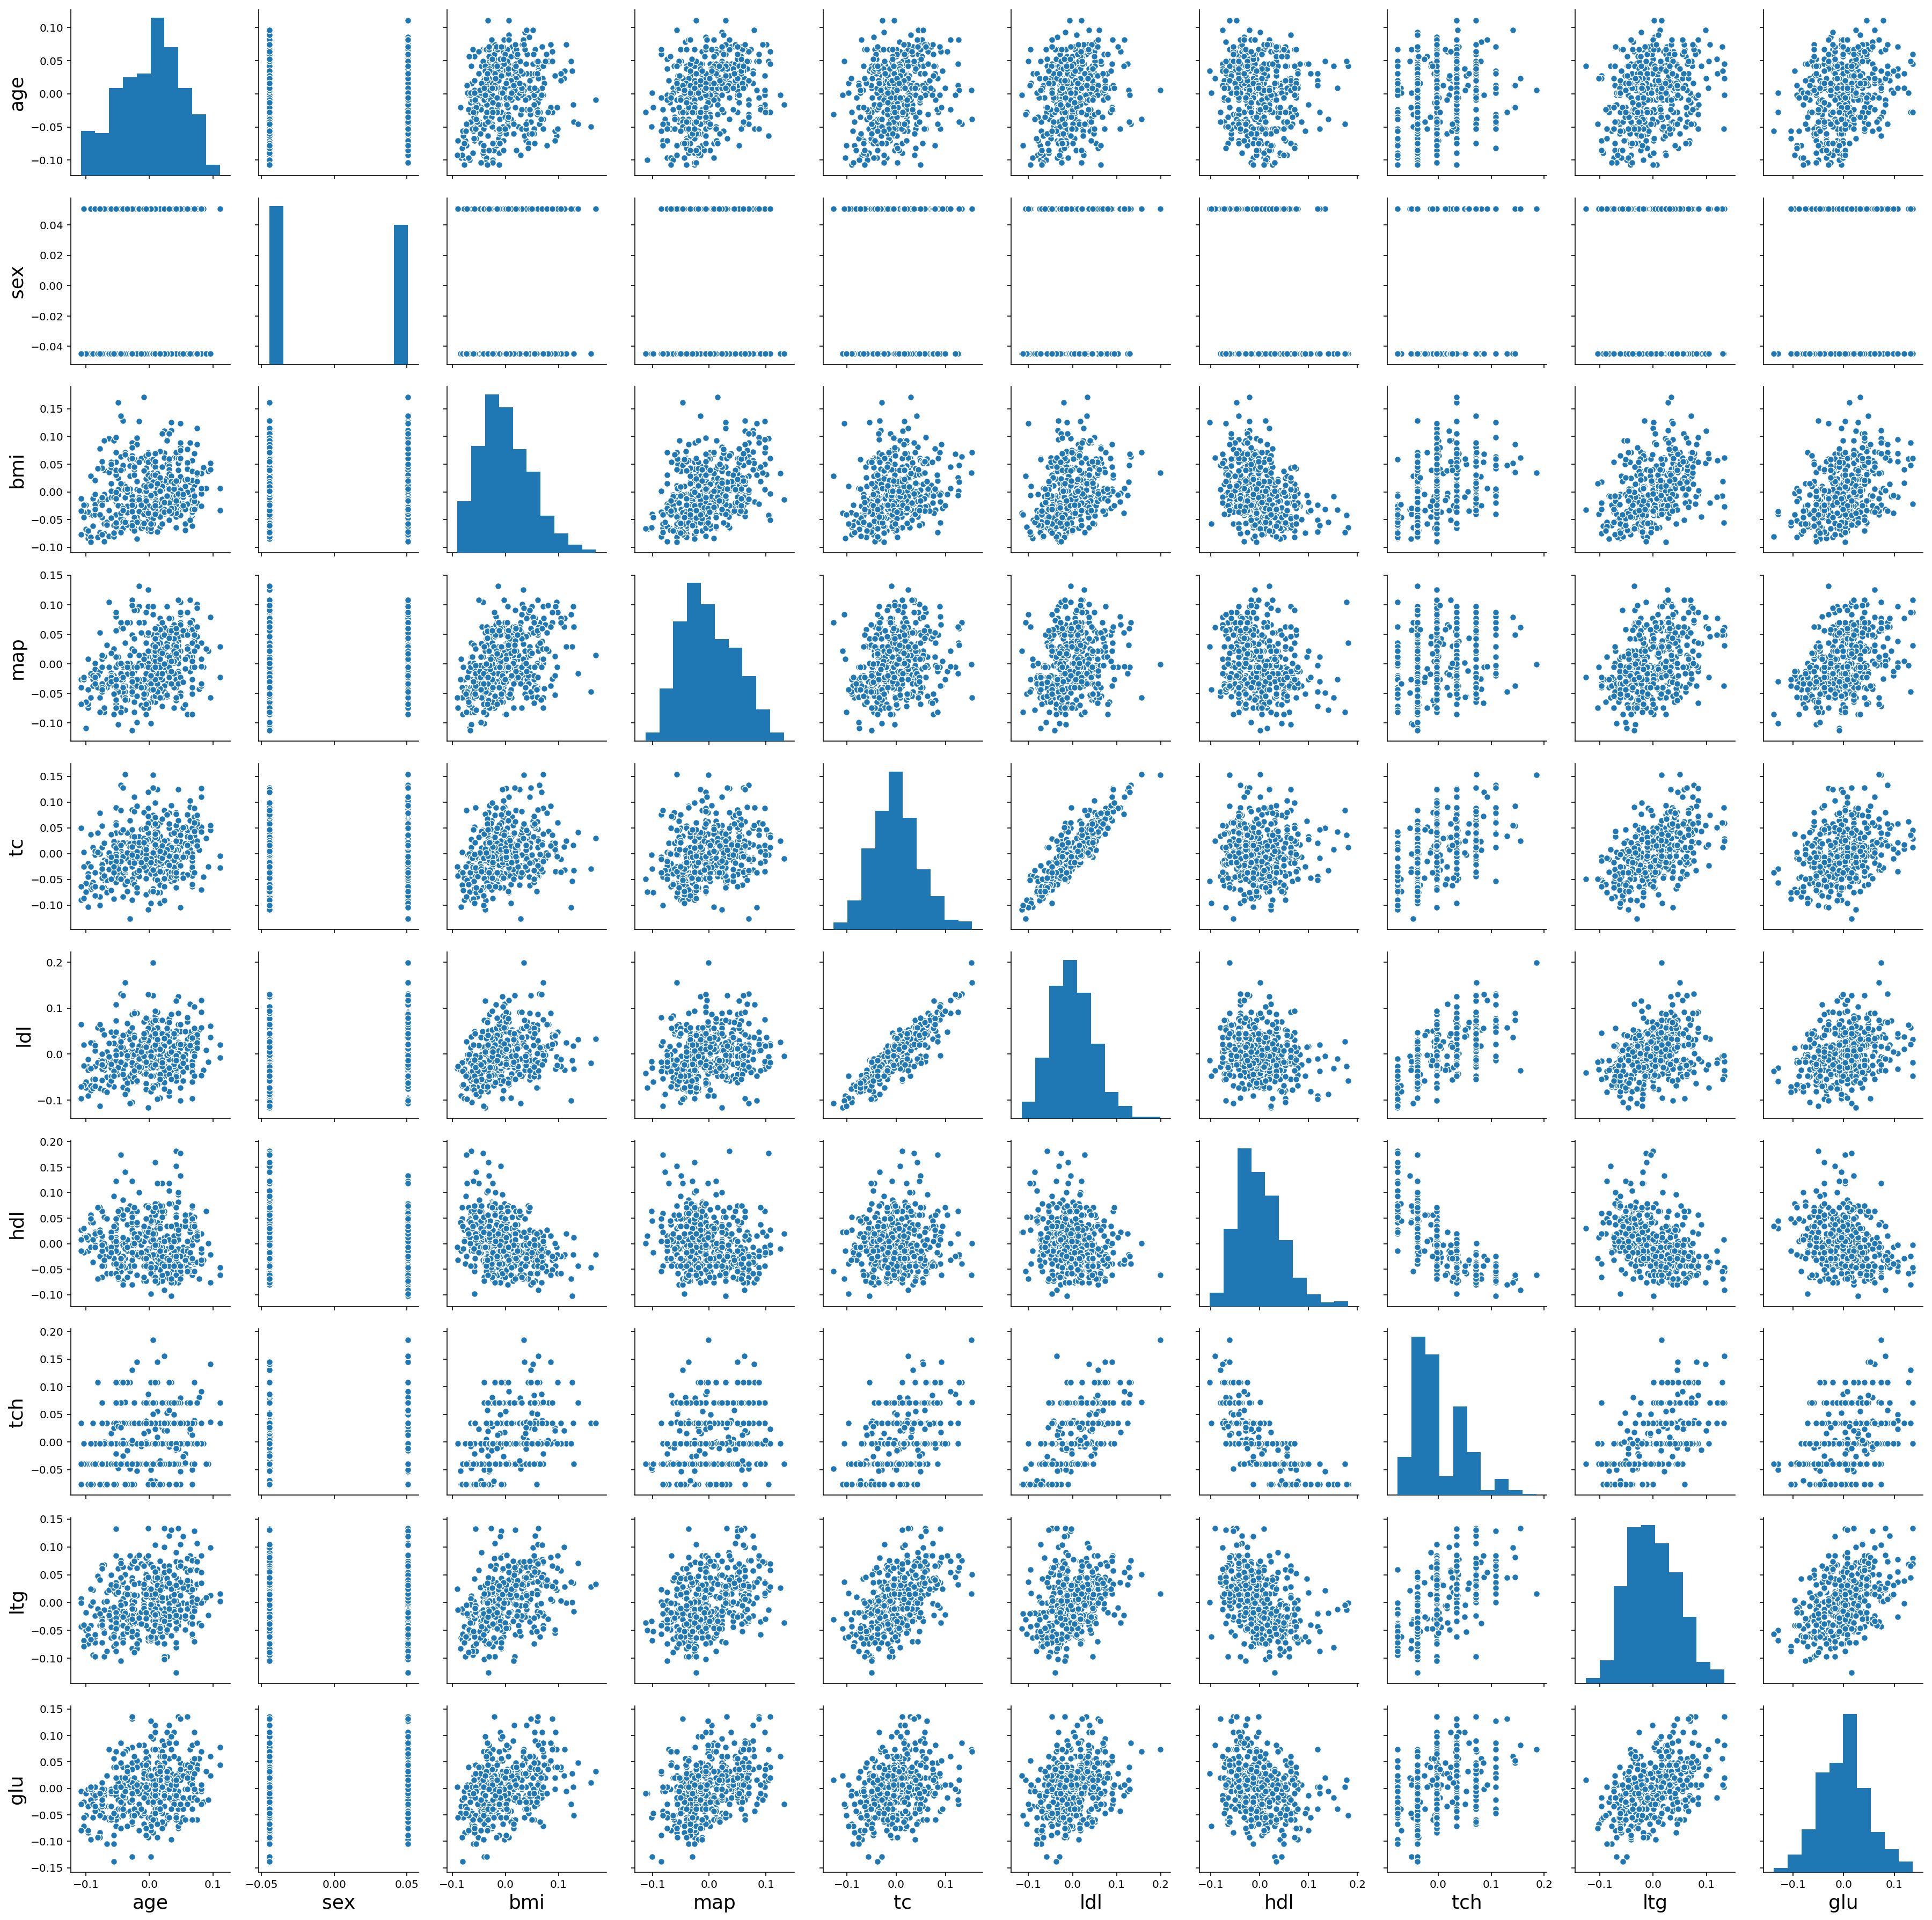

In [117]:
import seaborn as sns

sns.pairplot(df);

---
## Ordinary least squares (OLS) regression

In [144]:
from sklearn.linear_model import LinearRegression

ols_model = LinearRegression(fit_intercept=False)
ols_model.fit(X, y);

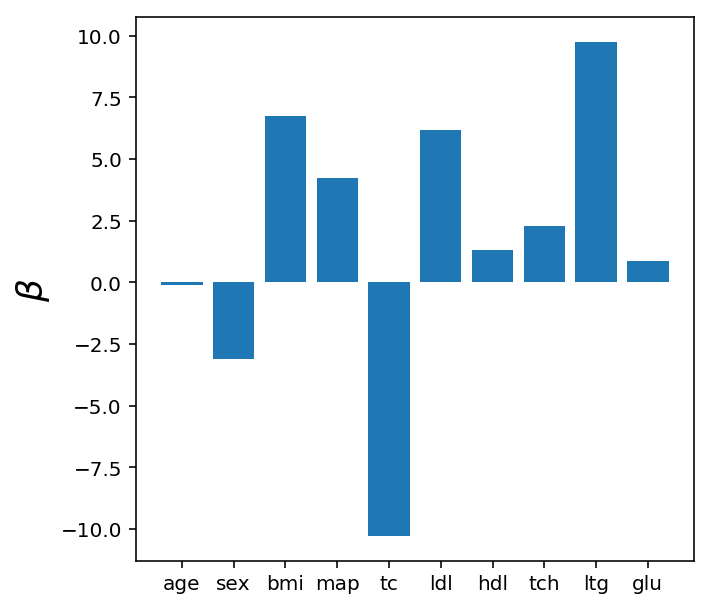

In [145]:
nfeatures = len(ols_model.coef_)

plt.bar(range(nfeatures), ols_model.coef_)
plt.xticks(range(nfeatures), features)
plt.ylabel(r'$\beta$');

### Model fit (prediction)

In [146]:
ols_yfit = ols_model.predict(X)

### Residuals

In [147]:
ols_residuals = y - ols_yfit

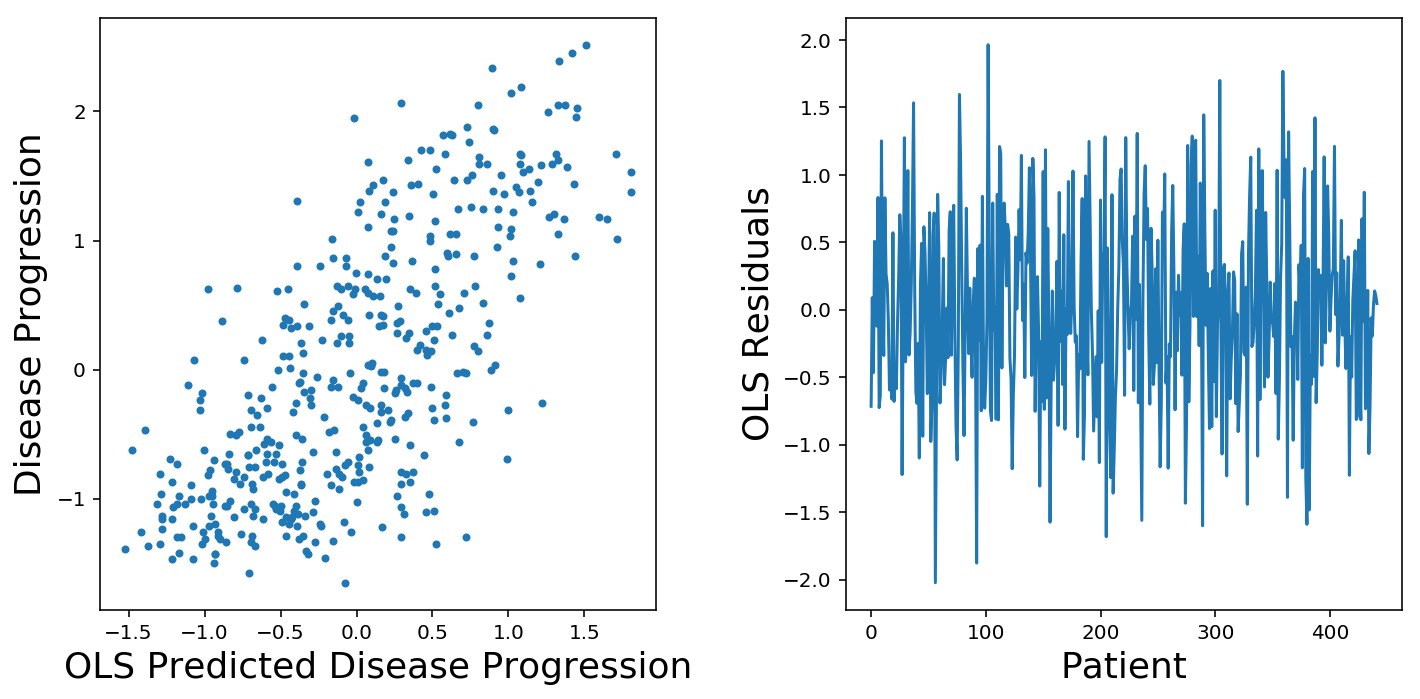

In [148]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(ols_yfit, y, '.')
plt.xlabel('OLS Predicted Disease Progression')
plt.ylabel('Disease Progression')

plt.subplot(122)
plt.plot(ols_residuals)
plt.xlabel('Patient')
plt.ylabel('OLS Residuals')

plt.tight_layout()

---
## How well did the model do?

## Sum of Squared Errors (SSE) $= \sum_i (y_i - yfit_i)^2 = \sum_i (residual_i)^2$

## Mean Squared Error (MSE) $= \frac{SSE}{N}$

## $R^2 = 1 - \frac{SSE}{\sum_i (y_i - mean(y))^2}$

In [149]:
sse = (ols_residuals**2).sum()
mse = sse / len(ols_residuals)
R2 = 1 - sse / ((y - y.mean())**2).sum()

df_results = pd.DataFrame(index=['SSE', 'MSE', 'R^2'])
df_results['OLS'] = [sse, mse, R2]

df_results

,OLS
SSE,213.154754
MSE,0.482251
R^2,0.517749


In [150]:
R2 = ols_model.score(X, y)
R2

0.5177494254132934

---
## Ridge Regularization

## Error to be minimized $= SSE + \alpha \sum_j \beta_j^2$

## Let's try $\alpha = 1$.

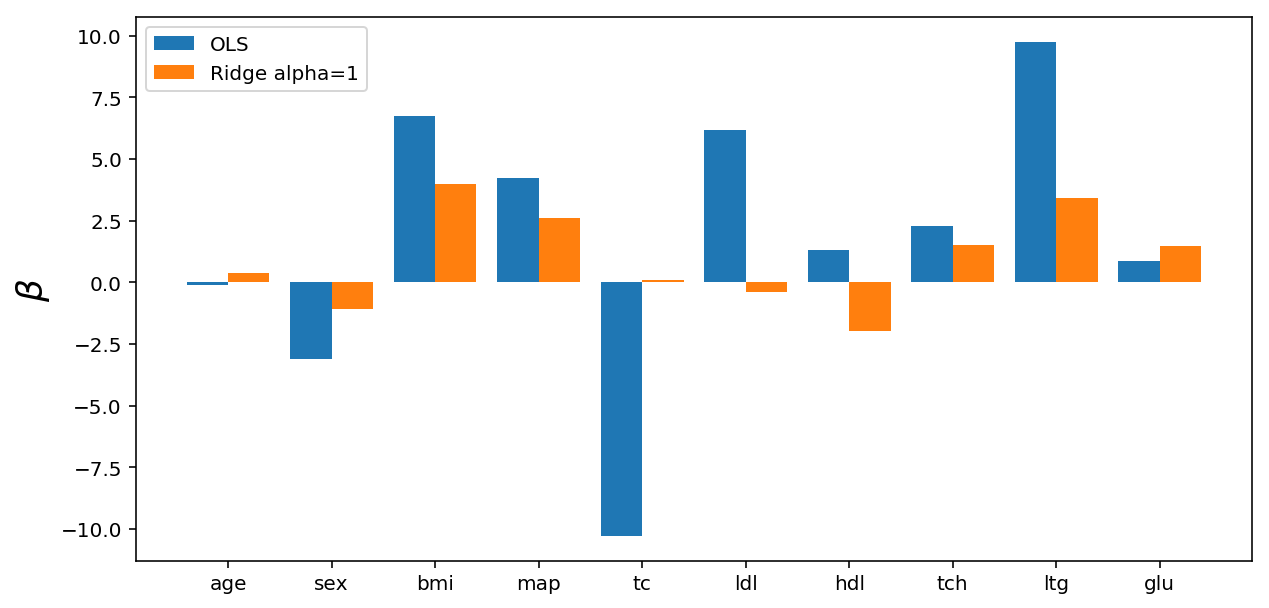

In [151]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1, fit_intercept=False)
ridge_model.fit(X, y)


plt.figure(figsize=(10, 5))
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.4, label='OLS')
plt.bar(xticks+0.2, ridge_model.coef_, width=0.4, label='Ridge alpha=1')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

## What did the Ridge model do to the weights of the highly correlated features as compared to the simple OLS model?

## How well did the Ridge model do?

In [152]:
residuals = y - ridge_model.predict(X)

sse = (residuals**2).sum()
mse = sse / len(residuals)
R2 = 1 - sse / ((y - y.mean())**2).sum()

df_results[r'Ridge $\alpha = 1$'] = [sse, mse, R2]

df_results

,OLS,Ridge $\alpha = 1$
SSE,213.154754,242.555724
MSE,0.482251,0.548769
R^2,0.517749,0.451231


---
## Ok, but what value should we use for $\alpha$ in Ridge regression?

## <font color=red>Exercises</font>

1. Fit the diabetes data set using a Ridge model with $\alpha = 0.01$.
2. Compute the MSE for the model fit and compare it to that for $\alpha = 1$.

---
## Let's try a bunch of different values for $\alpha$ and see how they do...

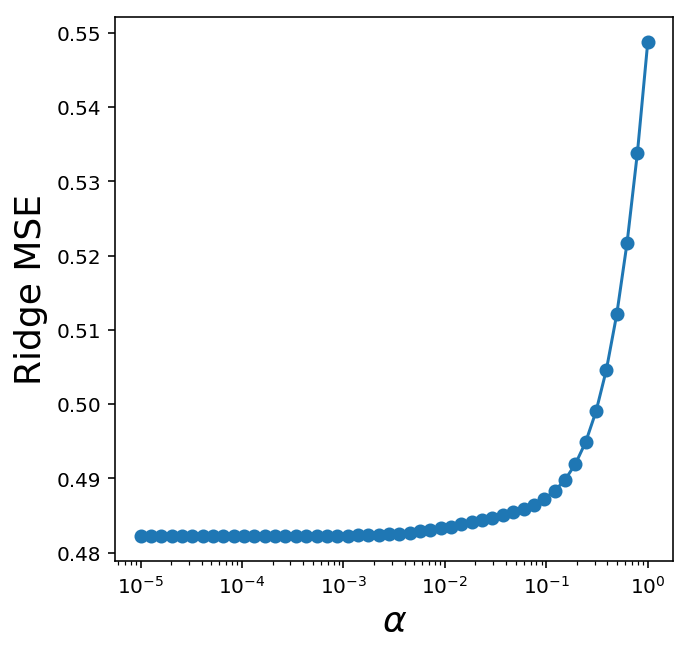

In [153]:
alphas = np.logspace(-5, 0, 50)

mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X, y)
    residuals = y - model.predict(X)
    sse = (residuals**2).sum()
    mse[i] = sse / len(residuals)

plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge MSE');

In [154]:
np.argmin(mse)

0

---
## Smallest $\alpha$ is best!

## But then absolute best would be $\alpha = 0$, which is just plain old OLS.

## Did ridge regularization not help?

---
## Training Error vs. Testing Error

![train vs test error](images/train-vs-test-error.png)

---
## Split the patients into two groups (training and testing).

In [129]:
ntest = 200

X_train = X[:-ntest, :]
X_test = X[-ntest:, :]

y_train = y[:-ntest]
y_test = y[-ntest:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((242, 10), (200, 10), (242,), (200,))

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.5, random_state=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((221, 10), (221, 10), (221,), (221,))

---
## Now fit the model on the training group ONLY and evaluate the error on the test group ONLY.

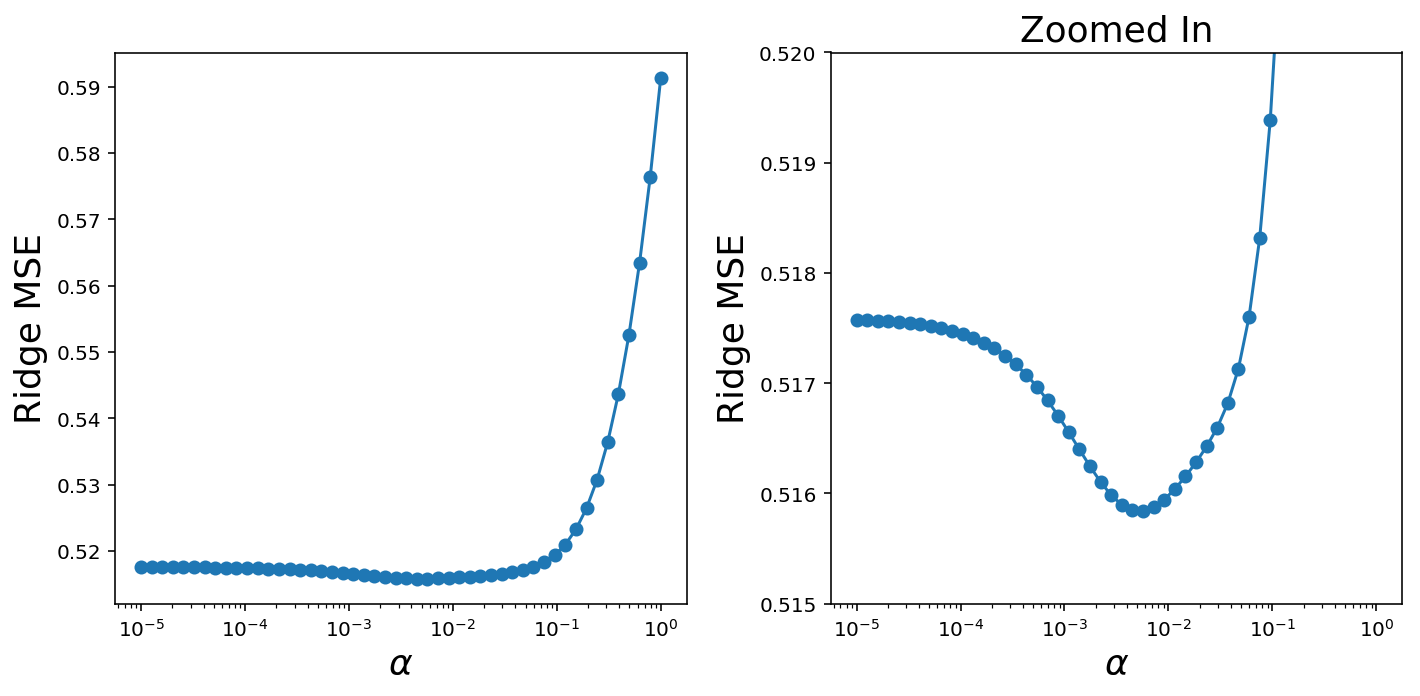

In [156]:
alphas = np.logspace(-5, 0, 50)

mse = np.zeros(alphas.shape)

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha, fit_intercept=False)
    model.fit(X_train, y_train)
    residuals = y_test - model.predict(X_test)
    sse = (residuals**2).sum()
    mse[i] = sse / len(residuals)


plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge MSE');

plt.subplot(122)
plt.plot(alphas, mse, 'o-')
plt.ylim([0.515, 0.52])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Ridge MSE')
plt.title('Zoomed In');

plt.tight_layout();

---
## The best model has the minimum testing MSE for $\alpha \approx 0.005$?

In [157]:
np.argmin(mse)

27

In [158]:
alphas[np.argmin(mse)]

0.005689866029018299

In [159]:
df_results[r'Ridge $\alpha \approx 0.005$'] = [np.nan, mse[np.argmin(mse)], np.nan]

df_results

,OLS,Ridge $\alpha = 1$,Ridge $\alpha \approx 0.005$
SSE,213.154754,242.555724,NaN
MSE,0.482251,0.548769,0.515841
R^2,0.517749,0.451231,NaN


---
## Now there is a best fit $\alpha \approx 0.005$

## <font color=magenta>But the MSE is still worse than for OLS. What gives?</font>

---
## To appropriately compare simple OLS vs. Ridge for $\alpha \approx 0.005$, we need to use the same train/test split for each.

In [160]:
ols_model = LinearRegression(fit_intercept=False)

# Fit the OLS model to the training data set
ols_model.fit(X_train, y_train)

# Evaluate the MSE on the testing data set
residuals = y_test - ols_model.predict(X_test)
ols_mse = np.sum(residuals**2) / len(residuals)

In [161]:
ridge_model = Ridge(alpha=0.005, fit_intercept=False)

# Fit the Ridge model to the training data set
ridge_model.fit(X_train, y_train)

# Evaluate the MSE on the testing data set
residuals = y_test - ridge_model.predict(X_test)
ridge_mse = np.sum(residuals**2) / len(residuals)

In [175]:
df = pd.DataFrame(index=['test MSE'])
df['OLS'] = ols_mse
df['Ridge'] = ridge_mse

df

,OLS,Ridge
test MSE,0.517591,0.51584


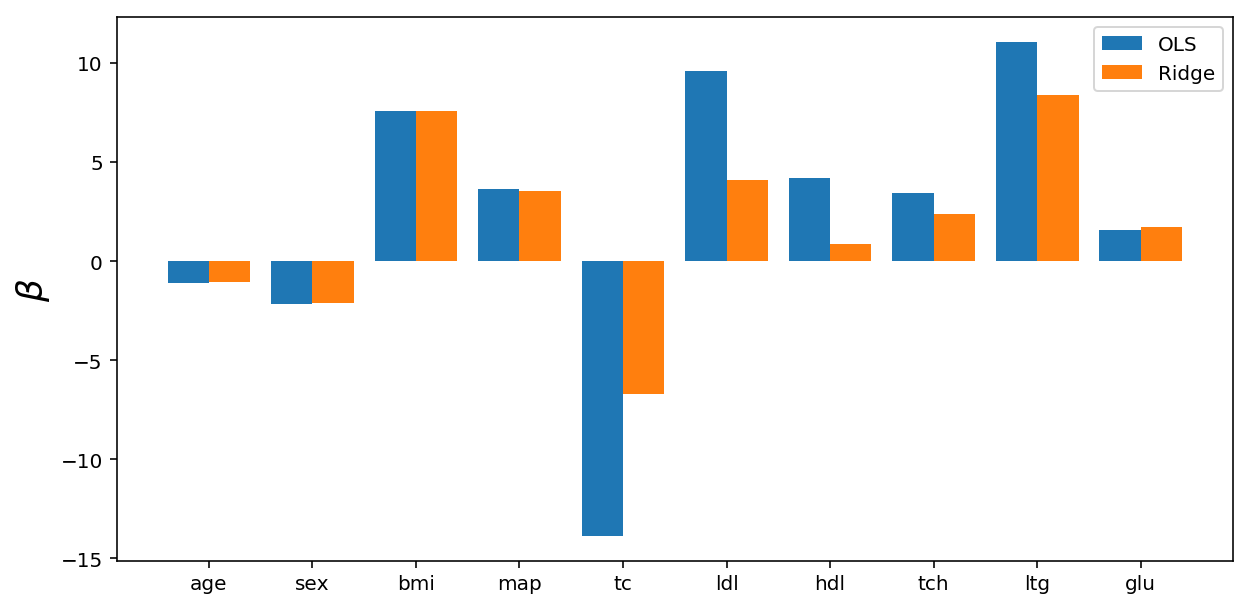

In [167]:
plt.figure(figsize=(10, 5))
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.4, label='OLS')
plt.bar(xticks+0.2, ridge_model.coef_, width=0.4, label='Ridge')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

---
## Why might the Ridge model perform better on data that the model was not explicitly trained (fit) on?

---
## Cross Validation are methods for splitting up data into training and testing sets.

## We'll cover this in more detail next lecture.

## But for now, know that the `RidgeCV` class does all of this for you.

In [168]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-5, 0, 50)
ridgecv_model = RidgeCV(alphas, store_cv_values=True)
ridgecv_model.fit(X, y)

ridgecv_model.alpha_, ridgecv_model.coef_

(0.004498432668969444,
 array([-0.10888074, -3.07822983,  6.76673992,  4.1853826 , -6.8713724 ,
         3.4813839 , -0.18835902,  1.89932361,  8.44999498,  0.90252904]))

In [169]:
ridgecv_model.cv_values_.shape

(442, 50)

In [170]:
mse = ridgecv_model.cv_values_.mean(axis=0)

mse.shape

(50,)

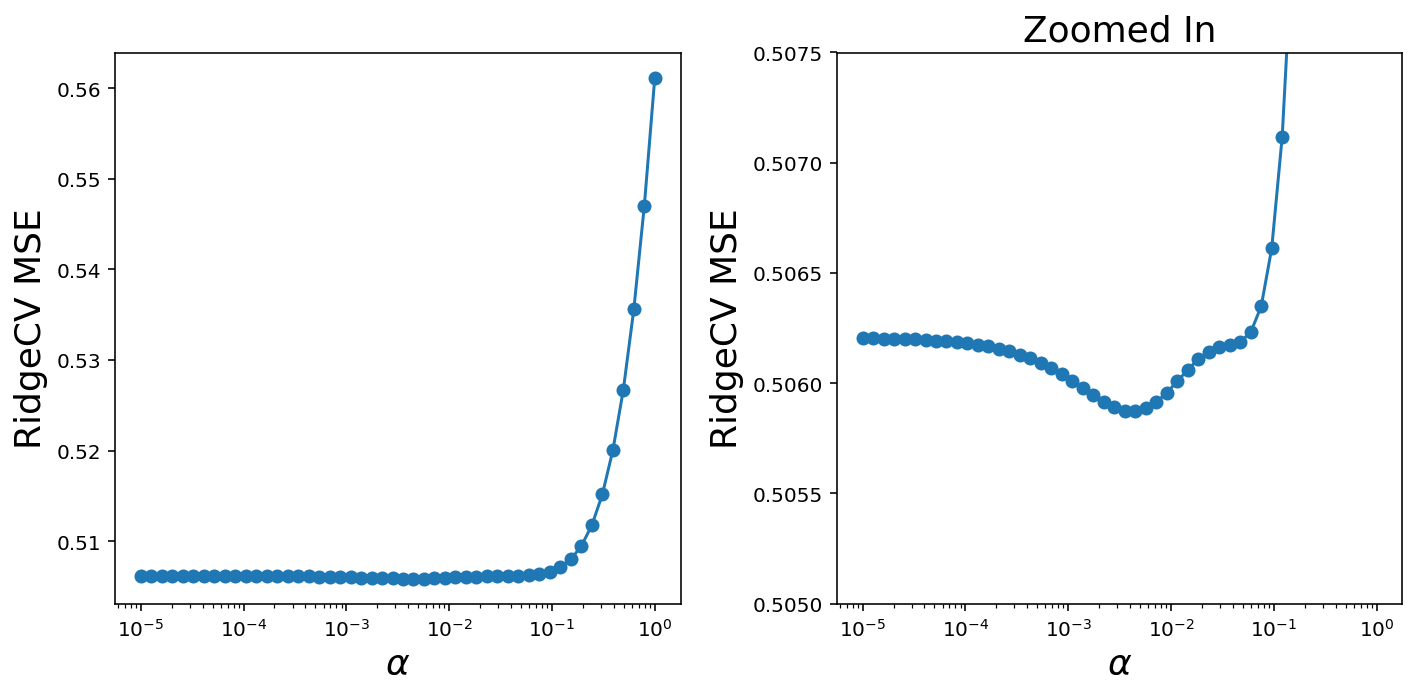

In [171]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(alphas, mse, 'o-')
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('RidgeCV MSE');

plt.subplot(122)
plt.plot(alphas, mse, 'o-')
plt.ylim([0.505, 0.5075])
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('RidgeCV MSE')
plt.title('Zoomed In');

plt.tight_layout();

In [172]:
np.argmin(mse), alphas[np.argmin(mse)]

(26, 0.004498432668969444)

In [176]:
df['RidgeCV'] = mse[np.argmin(mse)]

df

,OLS,Ridge,RidgeCV
test MSE,0.517591,0.51584,0.505873


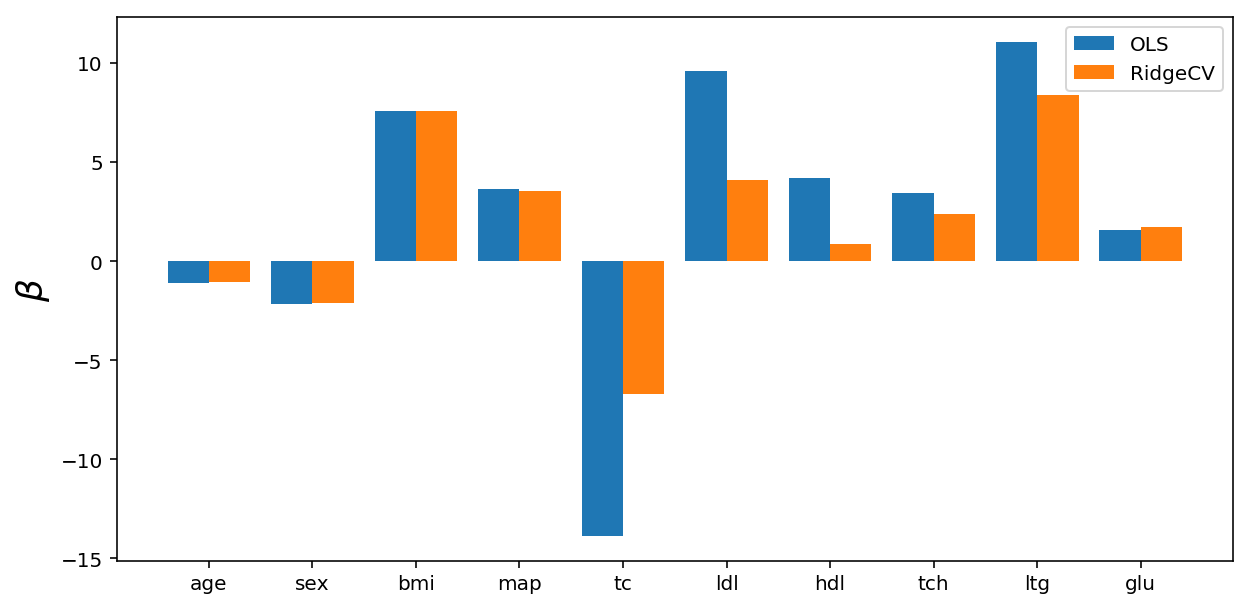

In [177]:
plt.figure(figsize=(10, 5))
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.4, label='OLS')
plt.bar(xticks+0.2, ridge_model.coef_, width=0.4, label='RidgeCV')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

---
## Lasso Regularization

## Error to be minimized $= SSE + \alpha \sum_j \beta_j$

In [180]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-5, 0, 50)
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(X, y)

lasso_model.alpha_, lasso_model.coef_

(5.1794746792312125e-05,
 array([-0.08237189, -3.06047606,  6.77776066,  4.16752444, -7.35422   ,
         3.88564136, -0.        ,  1.88012347,  8.68123072,  0.86660051]))

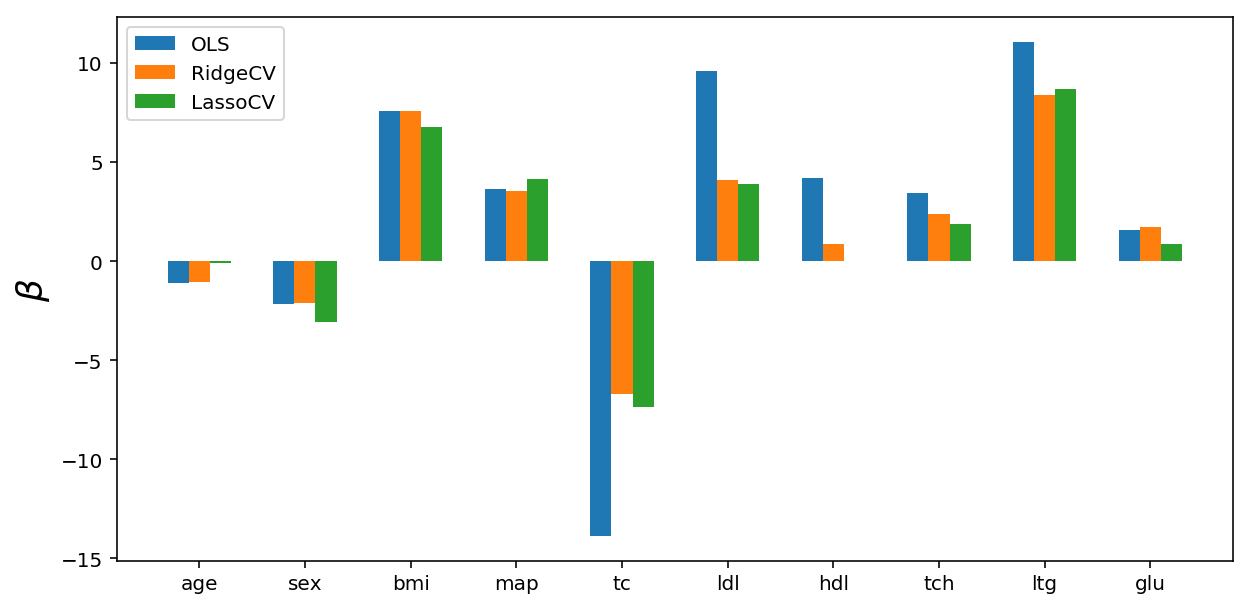

In [181]:
plt.figure(figsize=(10, 5))
xticks = np.arange(len(features))
plt.bar(xticks-0.2, ols_model.coef_, width=0.2, label='OLS')
plt.bar(xticks, ridge_model.coef_, width=0.2, label='RidgeCV')
plt.bar(xticks+0.2, lasso_model.coef_, width=0.2, label='LassoCV')
plt.xticks(xticks, features)
plt.ylabel(r'$\beta$')
plt.legend();

## What did the lasso model do to the value of small weights?

## Why might this be desirable?